#### Beamforming implementation by FK analysis
Author: Anmol Harshana   Date: 04/12/2021

The following code borrows heavily from: https://docs.obspy.org/tutorial/code_snippets/beamforming_fk_analysis.html

The details for data generation:

vert_force3D.ipynb: file used for data generation. 

Receiver positions: (x,y: circle of radius 100m with centee at (11000,11000,0)), z: 0 (on the surface)

Number of receivers = 101

Only z -axis data for the receivers will be utilized.

Source position: at (1000,1000,0). Note that in this case the z axis points downwards. 

The total time for recorded data: 20s.

Number of Samples = 810

Start and End time will be used as given default by ObsPy library. 

First step is to convert the receiver data into a a stream object and store it in a file in .mseed format for future reference. Then next step is to use the array processing function along with a polat plot visualization to get a sense of the direction of the source. 

Defined backazimuth: the angle measured between the vector pointing from the station to the source and the vector pointing from the station to the North. (https://docs.obspy.org/packages/autogen/obspy.signal.rotate.rotate_ne_rt.html)

In [1]:
# importing required libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

import numpy as np
import obspy
from obspy.core.util import AttribDict
from obspy.imaging.cm import obspy_sequential
from obspy.signal.array_analysis import array_processing
from obspy.core.trace import Trace
from obspy.core.stream import Stream
from scipy.stats import mode
np.random.seed(0)  # seeding random numbers generation

In [2]:
## Loading the data from data files 
z_data = np.genfromtxt('recz_data_circ100.csv',delimiter=',')   # data recorded in z direction
rec_x_pos = np.genfromtxt('recx_pos_circ100.csv',delimiter=',') # x coordinate of receiver position
rec_y_pos = np.genfromtxt('recy_pos_circ100.csv',delimiter=',') # y coordinate of receiver position
# Randomizing the receiver positions
np.random.seed(0)
#rec_x_pos = rec_x_pos + np.random.randint(0,100,101)
#rec_y_pos = rec_y_pos + np.random.randint(0,100,101)

In [3]:
# Now storing this data with proper format in a .mseed file
st =Stream()
#for i in range(1,101,2):  # for odd receivers
for i in range(0,101,2): # for even receivers
    stats = {'network': 'SATLAB', 'station': 'GLEE', 'location':str(rec_x_pos[i])+','+str(rec_y_pos[i]) ,
             'coordsys': 'xy','coordinates':AttribDict({'x': rec_x_pos[i],'y': rec_y_pos[i],'elevation': 0}),
         'channel': 'WLZ', 'npts': len(z_data[0]), 'sampling_rate': 17,
         'mseed': {'dataquality': 'D'}} # stats for receivers
    tr =Trace(data=z_data[i,:]*(-1)**np.random.randint(low=0,high=2), header=stats)   # creating a trace for 1 receiver
    st.append(tr)
    
#st.write('Exp_5.mseed') # storing data in .mseed file for later purposes

In [4]:
# Now checking the stats of one of the traces

st[0].stats

         network: SATLAB
         station: GLEE
        location: 11100.0,11000.0
         channel: WLZ
       starttime: 1970-01-01T00:00:00.000000Z
         endtime: 1970-01-01T00:00:47.588235Z
   sampling_rate: 17.0
           delta: 0.058823529411764705
            npts: 810
           calib: 1.0
     coordinates: AttribDict({'x': 11100.0, 'y': 11000.0, 'elevation': 0})
        coordsys: xy
           mseed: AttribDict({'dataquality': 'D'})

Now we have a proper seismic object for processing. Now  implementing beamforming.

In [5]:
kwargs = dict(
    # slowness grid: X min, X max, Y min, Y max, Slow Step
    sll_x=-0.0005, slm_x=0.0005, sll_y=-0.0005, slm_y=0.0005, sl_s=0.0005,coordsys='xy',
    # sliding window properties
    win_len=1.0, win_frac=0.5,
    # frequency properties
    frqlow=1.0, frqhigh=20.0, prewhiten=0,
    # restrict output
    semb_thres=-1e9, vel_thres=-1e9,
    stime=obspy.UTCDateTime("19700101000000"),
    etime=obspy.UTCDateTime("19700101000019.95720")
)   # arguments for array processing
out = array_processing(st, **kwargs)

In [6]:
# Separately storing time, rel_power,abs_power, backazimuth and slowness

t, rel_power, abs_power, baz, slow = out.T
baz[baz < 0.0] += 360   


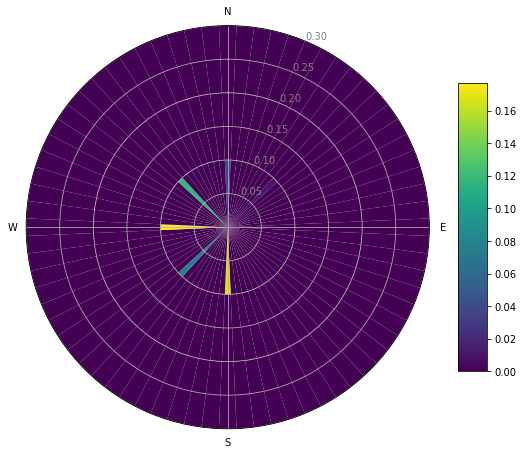

In [7]:
# choose number of fractions in plot (desirably 360 degree/N is an integer!)
N = 72
N2 = 30
abins = np.arange(N + 1) * 360. / N
sbins = np.linspace(0, 3, N2 + 1)
cmap = obspy_sequential

# sum rel power in bins given by abins and sbins
hist, baz_edges, sl_edges = \
    np.histogram2d(baz, slow, bins=[abins, sbins], weights=rel_power)

# transform to radian
baz_edges = np.radians(baz_edges)

# add polar and colorbar axes
fig = plt.figure(figsize=(8, 8))
cax = fig.add_axes([0.85, 0.2, 0.05, 0.5])
ax = fig.add_axes([0.10, 0.1, 0.70, 0.7], polar=True)
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")

dh = abs(sl_edges[1] - sl_edges[0])
dw = abs(baz_edges[1] - baz_edges[0])

# circle through backazimuth
for i, row in enumerate(hist):
    bars = ax.bar((i * dw) * np.ones(N2),height=dh * np.ones(N2),width=dw, bottom=dh * np.arange(N2),color=cmap(row / hist.max()))

ax.set_xticks(np.linspace(0, 2 * np.pi, 4, endpoint=False))
ax.set_xticklabels(['N', 'E', 'S', 'W'])

# set slowness limits
ax.set_ylim(0, 0.3)
[i.set_color('grey') for i in ax.get_yticklabels()]
ColorbarBase(cax, cmap=cmap,
             norm=Normalize(vmin=hist.min(), vmax=hist.max()))
plt.show()


In [8]:
baz

array([  45.,    0.,  225.,  270.,    0.,  270.,  225.,  180.,  270.,
        225.,  180.,  180.,  315.,  270.,  270.,  315.,  180.,  180.,
        270.,  180.,  180.,  315.,  225.,  315.,  270.])

The results for small subsets can be plotted easily and checked just by alterinng the parameters of range while making the stream object. 

In [9]:
# Defining the number of subsets and deciding the number of receivers in each 
rec_index = np.arange(0,101,1)
np.random.seed(0)
np.random.shuffle(rec_index)
# We can use the subsets of the above randomized index array for further processsing



In [10]:
def polar_plot_FK_analysis(baz,slow,n_baz,n_slow):
    '''The function plots the polar plot with given back azimuth and slowness. The backazimuth is denoted with angles with 
    North while the slowness is shown along the radial measurements.The body of the function is taken from the Fk analysis
    code example in ObsPy tutorials. 
    baz = backazimuth
    slow = slowness
    n_baz = number of partitions for backazimuth
    n_slow = number of partitions for slowness'''
    # choose number of fractions in plot (desirably 360 degree/N is an integer!)
    N = n_baz
    N2 = n_slow
    abins = np.arange(N + 1) * 360. / N
    sbins = np.linspace(0, 3, N2 + 1)
    cmap = obspy_sequential

    # sum rel power in bins given by abins and sbins
    hist, baz_edges, sl_edges = \
        np.histogram2d(baz, slow, bins=[abins, sbins], weights=rel_power)

    # transform to radian
    baz_edges = np.radians(baz_edges)

    # add polar and colorbar axes
    fig = plt.figure(figsize=(8, 8))
    cax = fig.add_axes([0.85, 0.2, 0.05, 0.5])
    ax = fig.add_axes([0.10, 0.1, 0.70, 0.7], polar=True)
    ax.set_theta_direction(-1)
    ax.set_theta_zero_location("N")

    dh = abs(sl_edges[1] - sl_edges[0])
    dw = abs(baz_edges[1] - baz_edges[0])

    # circle through backazimuth
    for i, row in enumerate(hist):
        bars = ax.bar((i * dw) * np.ones(N2),height=dh * np.ones(N2),width=dw, bottom=dh * np.arange(N2),color=cmap(row / hist.max()))

    ax.set_xticks(np.linspace(0, 2 * np.pi, 4, endpoint=False))
    ax.set_xticklabels(['N', 'E', 'S', 'W'])

    # set slowness limits
    ax.set_ylim(0, 0.3)
    [i.set_color('grey') for i in ax.get_yticklabels()]
    ColorbarBase(cax, cmap=cmap,
                 norm=Normalize(vmin=hist.min(), vmax=hist.max()))
    plt.show()

    return 
    

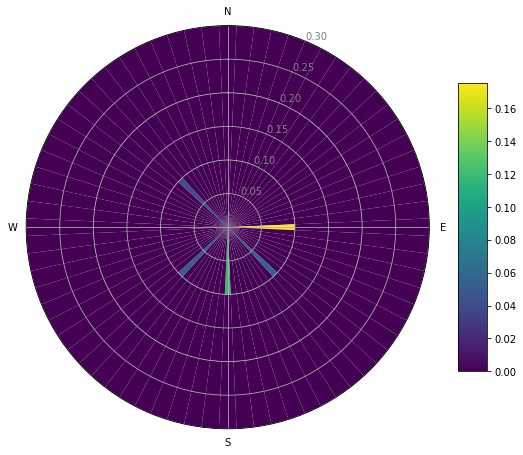

In [11]:
# creating new stream objects
for i in range(10,20):  # change the entries for a new subset
    r_index = rec_index[i]
    stats = {'network': 'SATLAB', 'station': 'GLEE', 'location':str(rec_x_pos[r_index])+','+str(rec_y_pos[r_index]) ,
             'coordsys': 'xy','coordinates':AttribDict({'x': rec_x_pos[r_index],'y': rec_y_pos[r_index],'elevation': 0}),
         'channel': 'WLZ', 'npts': len(z_data[0]), 'sampling_rate': 17,
         'mseed': {'dataquality': 'D'}} # stats for receivers
    tr =Trace(data=z_data[r_index,:]*(-1)**np.random.randint(low=0,high=2), header=stats)   # creating a trace for 1 receiver
    st.append(tr)
kwargs = dict(
    # slowness grid: X min, X max, Y min, Y max, Slow Step
    sll_x=-0.005, slm_x=0.005, sll_y=-0.005, slm_y=0.005, sl_s=0.005,coordsys='xy',
    # sliding window properties
    win_len=1.0, win_frac=0.5,
    # frequency properties
    frqlow=1.0, frqhigh=20.0, prewhiten=0,
    # restrict output
    semb_thres=-1e9, vel_thres=-1e9,
    stime=obspy.UTCDateTime("19700101000000"),
    etime=obspy.UTCDateTime("19700101000019.95720")
)   # arguments for array processing
out = array_processing(st, **kwargs)
t, rel_power, abs_power, baz, slow = out.T
baz[baz < 0.0] += 360
polar_plot_FK_analysis(baz,slow,n_baz=72,n_slow=30)

In [12]:
baz_mean = np.zeros(10) # to store the mean back azimuth for each subset
baz_mode = np.zeros(10) # to store the most frequent back azimuth for each subset
# We can create an additional loop to run throught the subsets
for i in range(10):
    for j in range(i*10,i*10+10):  # change the entries for a new subset
        r_index = rec_index[j]  # the randomized indices
        stats = {'network': 'SATLAB', 'station': 'GLEE', 'location':str(rec_x_pos[r_index])+','+str(rec_y_pos[r_index]) ,
             'coordsys': 'xy','coordinates':AttribDict({'x': rec_x_pos[r_index],'y': rec_y_pos[r_index],'elevation': 0}),
             'channel': 'WLZ', 'npts': len(z_data[0]), 'sampling_rate': 17,
             'mseed': {'dataquality': 'D'}} # stats for receivers
        tr =Trace(data=z_data[r_index,:]*(-1)**np.random.randint(low=0,high=2), header=stats)   # creating a trace for 1 receiver
        st.append(tr)
    kwargs = dict(
        # slowness grid: X min, X max, Y min, Y max, Slow Step
        sll_x=-0.0005, slm_x=0.0005, sll_y=-0.0005, slm_y=0.0005, sl_s=0.0005,coordsys='xy',
        # sliding window properties
        win_len=1.0, win_frac=0.5,
        # frequency properties
        frqlow=1.0, frqhigh=20.0, prewhiten=0,
        # restrict output
        semb_thres=-1e9, vel_thres=-1e9,
        stime=obspy.UTCDateTime("19700101000000"),
        etime=obspy.UTCDateTime("19700101000019.95720")
    )   # arguments for array processing
    out = array_processing(st, **kwargs)
    t, rel_power, abs_power, baz, slow = out.T
    baz[baz < 0.0] += 360
    baz_mean[i] = np.mean(baz)
    baz_mode[i] =mode(baz)[0] # only returning the mode

In [13]:
print('The mean backazimuth for the 33 subsets: ',baz_mean,'The overall mean is',np.mean(baz_mean))
print('The modal backazimuth for the 33 subsets: ',baz_mode,'The overall mean of the modes is',np.mean(baz_mode))

The mean backazimuth for the 33 subsets:  [ 225.   223.2  117.    79.2   95.4  108.   127.8  129.6  122.4  124.2] The overall mean is 135.18
The modal backazimuth for the 33 subsets:  [ 180.  270.   90.   90.   90.   90.   90.   90.   90.   90.] The overall mean of the modes is 117.0


The velocity estimation is done using the obtained slowness and the returned backazimuth. This can also verify whether the processed data actually matches the source. 

In [14]:
#Checking the results with subset breakage in sequence

baz_mean = np.zeros(10) # to store the mean back azimuth for each subset
baz_mode = np.zeros(10) # to store the most frequent back azimuth for each subset
# We can create an additional loop to run throught the subsets
for i in range(10):
    for j in range(i*10,i*10+10):  # change the entries for a new subset
        r_index = j  
        stats = {'network': 'SATLAB', 'station': 'GLEE', 'location':str(rec_x_pos[r_index])+','+str(rec_y_pos[r_index]) ,
             'coordsys': 'xy','coordinates':AttribDict({'x': rec_x_pos[r_index],'y': rec_y_pos[r_index],'elevation': 0}),
             'channel': 'WLZ', 'npts': len(z_data[0]), 'sampling_rate': 17,
             'mseed': {'dataquality': 'D'}} # stats for receivers
        tr =Trace(data=z_data[r_index,:]*(-1)**np.random.randint(low=0,high=2), header=stats)   # creating a trace for 1 receiver
        st.append(tr)
    kwargs = dict(
        # slowness grid: X min, X max, Y min, Y max, Slow Step
        sll_x=-0.0005, slm_x=0.0005, sll_y=-0.0005, slm_y=0.0005, sl_s=0.0005,coordsys='xy',
        # sliding window properties
        win_len=1.0, win_frac=0.5,
        # frequency properties
        frqlow=1.0, frqhigh=20.0, prewhiten=0,
        # restrict output
        semb_thres=-1e9, vel_thres=-1e9,
        stime=obspy.UTCDateTime("19700101000000"),
        etime=obspy.UTCDateTime("19700101000019.95720")
    )   # arguments for array processing
    out = array_processing(st, **kwargs)
    t, rel_power, abs_power, baz, slow = out.T
    baz[baz < 0.0] += 360
    
    baz_mean[i] = np.mean(baz)
    baz_mode[i] =mode(baz)[0] # only returning the mode

In [15]:
print('The mean backazimuth for the 33 subsets: ',baz_mean,'The overall mean is',np.mean(baz_mean))
print('The modal backazimuth for the 33 subsets: ',baz_mode,'The overall mean of the modes is',np.mean(baz_mode))

The mean backazimuth for the 33 subsets:  [ 111.6  118.8  111.6  117.   100.8   99.    75.6  108.   243.   243. ] The overall mean is 132.84
The modal backazimuth for the 33 subsets:  [  45.   90.   45.   90.   45.   90.   45.   45.  315.  315.] The overall mean of the modes is 112.5


Plotting a straight line from the subset's geometric center with the given azimuth and checking the intersection of those lines. We could then check whether the backazimuth value given is consistent or not.
First, plotting for only 3 subsets. 

(-600.0, 12600.0, -10.019272582051826, 22210.404724223088)

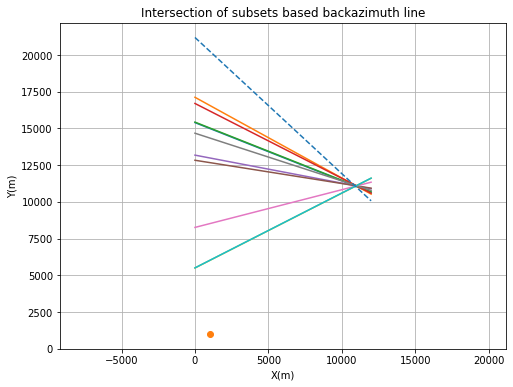

In [16]:
plt.figure(figsize = (8,6))
for i in range(10):
    initial_point =  np.array([np.mean(rec_x_pos[3*i:3*i+3]),np.mean(rec_y_pos[3*i:3*i+3])])  # denotes the initial point for starting the line
    slope = np.tan((90 - baz_mean[i])*np.pi/180)
    x_coordinates = np.array([0,12000])
    y_coordinates = np.array([initial_point[1] + slope*(0-initial_point[0]),initial_point[1] + slope*(12000-initial_point[0])])
    plt.plot(x_coordinates,y_coordinates)
plt.plot(np.array([0,12000]),np.array([11000 + np.tan((90 -np.mean(baz_mean))*np.pi/180)*(0-11000),11000 + np.tan((90 - np.mean(baz_mean))*np.pi/180)*(12000-11000)]),'--')
plt.plot(1000,1000,'o',label='Source')
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.title('Intersection of subsets based backazimuth line')
plt.grid()
plt.axis('equal')